In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import sklearn.model_selection as ms
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import pydotplus
from IPython.display import Image

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from sklearn.dummy import DummyClassifier

df = pd.read_csv("../dataset.csv")

<b>Preprocessing</b>

In [2]:
#fill missing values and fix upcase letters
df = df.sort_values(by='familiarity')
df.reset_index(drop=True, inplace=True)
miss_vals = dict(df['web_corpus_freq'].isna())
check_val = []
for x in miss_vals:
    if miss_vals[x] == True:
        check_val.append(x)
        #substitute the missing values with the mean values at the previous and following index
        df.loc[x, 'web_corpus_freq'] = (df['web_corpus_freq'].iloc[x-1]+df['web_corpus_freq'].iloc[x+1])/2
        #fix the uppercase letters
        df.loc[x, 'word'] = df['word'].iloc[x].lower()
df = df.sort_values(by='word') 
df.reset_index(drop=True, inplace=True)

#log transformation of web corpus
df['web_corpus_freq'] = np.log(df['web_corpus_freq'])
df = df.rename({'web_corpus_freq' : 'log_web_corpus_freq'}, axis='columns')

df_bckp = df.copy(deep=True)
raw = df.drop(columns=['word', 'polysemy', 'length'])

#rescaling the features for KNN
X = raw.values
minmax = MinMaxScaler()
X_scaled = minmax.fit_transform(X)

#dropping word
column2drop = ['word']
df.drop(column2drop, axis=1, inplace=True)

<b>Train-Test split</b>

In [3]:
#holding-out 0.3 for testing, I'll use polysemy as target variable

attributes = [col for col in df.columns if col != 'polysemy']
X = df[attributes].values
y = df['polysemy']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

<b>Undersampling</b>

In [4]:
base_to_undersample = pd.DataFrame(X_train, columns = ['length', 1,2,3,4,5,6,7,8,9,10])
base_to_undersample['polysemy'] = y_train.to_list()
y_train.value_counts() #just to quickly look at how much should I sample

0    3012
1     265
Name: polysemy, dtype: int64

In [5]:
to_undersample = base_to_undersample[base_to_undersample['polysemy'] == 0]
minority_class = base_to_undersample[base_to_undersample['polysemy'] == 1]
to_undersample.describe()

,length,1,2,3,4,5,6,7,8,9,10,polysemy
count,3012.000000,3012.000000,3012.000000,3012.000000,3012.000000,3012.000000,3012.000000,3012.000000,3012.000000,3012.000000,3012.000000,3012.0
mean,6.495684,4.711367,5.067301,5.031027,4.515539,4.690971,5.248513,4.193140,4.184042,4.092452,15.506173,0.0
std,2.011668,1.107891,1.649433,0.961764,1.447134,1.373984,0.927642,1.240236,1.020308,0.921819,1.832317,0.0
min,2.000000,2.057000,1.030000,1.941000,1.636000,1.737000,1.735000,1.219000,1.375000,1.088000,9.454854,0.0
25%,5.000000,3.871000,3.938750,4.471000,3.194000,3.486000,4.667000,3.200000,3.500000,3.576000,14.209453,0.0
50%,6.000000,4.600000,5.281000,5.118000,4.394000,4.618000,5.412000,4.238500,4.235000,4.118000,15.459878,0.0
75%,8.000000,5.471000,6.125000,5.614250,5.936000,6.029000,5.941000,5.200000,4.912000,4.645500,16.785070,0.0
max,16.000000,8.177000,8.647000,8.371000,6.931000,6.941000,6.939000,6.786000,6.788000,6.971000,21.427580,0.0


In [6]:
#as it can be seen I preferred to sample stratifying according to length (which is easily one of the most important features)
data_0_1 = to_undersample.query("length >= 0 & length < 5").sample(n=67,random_state=42)
data_0_2 = to_undersample.query("length >= 5 & length < 6").sample(n=66,random_state=42)
data_0_3 = to_undersample.query("length >= 6 & length < 8").sample(n=66,random_state=42)
data_0_4 = to_undersample.query("length >= 8 & length < 16").sample(n=66,random_state=42)

#I concatenate everything
new_data = data_0_1.append(data_0_2).append(data_0_3).append(data_0_4)
#I append polysemy back
new_train = minority_class.append(new_data, ignore_index=True)
#I shuffle the dataframe (otherwise I would have to do it later to avoid performing biased gridsearches)
new_train = new_train.sample(frac=1, random_state=42).reset_index(drop=True)

In [7]:
new_train

,length,1,2,3,4,5,6,7,8,9,10,polysemy
0,6.0,4.943,5.206,5.030,3.559,3.788,4.394,4.943,3.912,4.177,13.846597,1
1,6.0,6.103,4.625,5.656,2.531,2.688,3.767,5.750,4.400,5.429,14.234597,0
2,5.0,5.061,5.909,5.515,6.879,6.688,6.484,2.303,2.969,1.618,16.116242,1
3,5.0,4.219,4.515,4.594,3.333,3.849,5.552,4.788,4.438,3.767,18.232030,0
4,4.0,4.909,4.750,3.813,3.719,3.758,6.355,3.323,5.250,4.267,20.442791,0
...,...,...,...,...,...,...,...,...,...,...,...,...
525,5.0,3.438,4.712,4.292,3.758,3.470,6.016,3.846,3.825,3.862,15.400790,1
526,5.0,4.059,3.944,5.235,4.200,3.429,4.029,4.972,3.853,5.286,14.597222,1
527,4.0,5.467,4.607,4.742,6.387,6.125,5.310,3.438,3.469,3.885,16.519752,0
528,7.0,3.529,4.941,4.677,5.000,4.543,5.129,5.559,4.000,4.853,17.108301,0


In [8]:
#I re-defain the training and test set and I hold a copy for applying knn on the same data
y_train = new_train['polysemy']
X_train = new_train.drop(columns=['polysemy']).values

knnX_train = X_train[:]
knny_train = y_train[:]
knnX_test = X_test[:]
knny_test = y_test[:]

len(df), X_train.shape[0], X_test.shape[0]

(4682, 530, 1405)

<b>Decision Tree</b>

In [9]:
#Gridsearch with cross validation

clf = DecisionTreeClassifier()

param_list = {'criterion': ['entropy', 'gini'],
             'max_depth': [None] + [2, 5, 10, 20],
             'min_samples_split': [2, 5, 10, 20],
             'min_samples_leaf': [1, 5, 10, 20]
             }

grid_search = GridSearchCV(clf, param_grid=param_list, cv=ms.KFold(n_splits=5), scoring='f1')
grid_search.fit(X_train, y_train)

res = grid_search.cv_results_

grid_search.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=5)

In [10]:
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
report(res)

Model with rank: 1
Mean validation score: 0.675 (std: 0.037)
Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}

Model with rank: 2
Mean validation score: 0.674 (std: 0.049)
Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 20}

Model with rank: 3
Mean validation score: 0.673 (std: 0.040)
Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5}

Model with rank: 4
Mean validation score: 0.672 (std: 0.032)
Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10}

Model with rank: 5
Mean validation score: 0.663 (std: 0.051)
Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 2}

Model with rank: 5
Mean validation score: 0.663 (std: 0.051)
Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 10}



In [11]:
#running the algorithm
clf = DecisionTreeClassifier(criterion='entropy',
                             max_depth=5,
                             min_samples_split=20,
                             min_samples_leaf=1,
                             )

clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_split=20)

In [12]:
#measuring feature importance
imp_dict = {attr: clf.feature_importances_[i] for i, attr in enumerate(attributes)}
importances = {k: v for k, v in sorted(imp_dict.items(), key=lambda item: item[1], reverse=True)} #so that they are sorted

Text(0.5, 1.0, 'Feature importance')

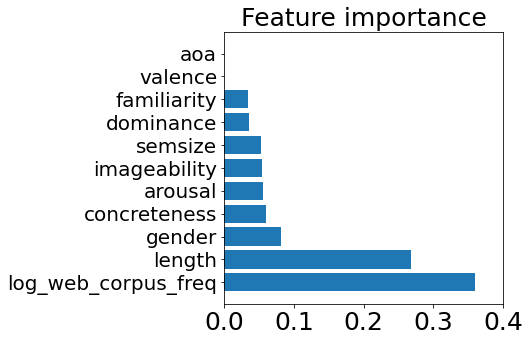

In [13]:
#I used a bar plot to measure feature importance
plt.figure(figsize=(5,5))
lista_nomi = [i for i in importances.keys()]
plt.barh(lista_nomi, importances.values())
plt.xticks(np.arange(0, 0.42, 0.1), fontsize=25)
plt.yticks(fontsize=20)
plt.title("Feature importance",fontsize=25)

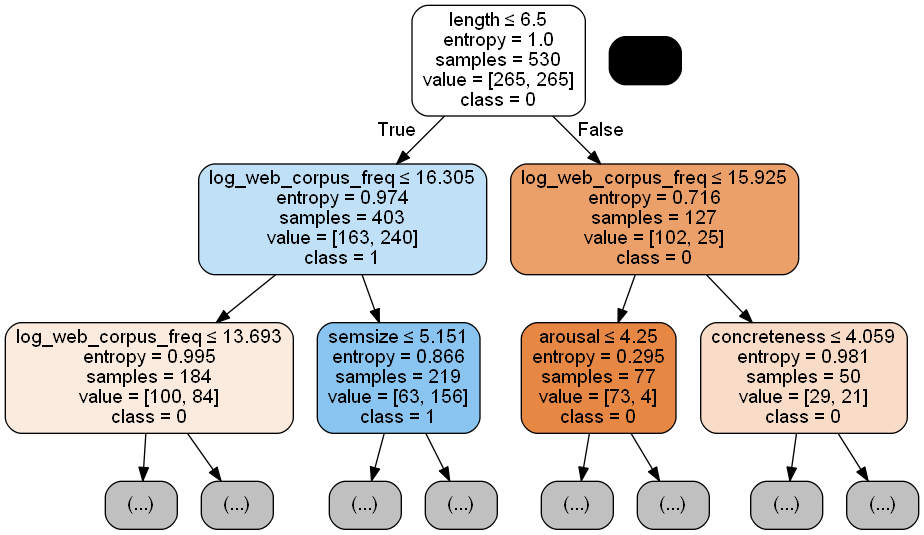

In [14]:
#just to visualize the tree
dot_data = tree.export_graphviz (clf, out_file=None,
                                feature_names=attributes,
                                class_names=[str(v) for v in clf.classes_],
                                filled=True, rounded=True,
                                special_characters=True,
                                max_depth=2)

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [15]:
#some metrics on the training
y_pred_train = clf.predict(X_train)
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.92      0.57      0.70       265
           1       0.69      0.95      0.80       265

    accuracy                           0.76       530
   macro avg       0.80      0.76      0.75       530
weighted avg       0.80      0.76      0.75       530



In [16]:
#confusion matrix
cf = confusion_matrix(y_train, y_pred_train, labels=[1,0])
print("True Positives: "+str(cf[0][0]), "False Negatives: "+str(cf[0][1]), "False Positives: "+str(cf[1][0]), "True Negatives: "+str(cf[1][1]), sep='\n')

True Positives: 252
False Negatives: 13
False Positives: 114
True Negatives: 151


In [17]:
y_pred_test = clf.predict(X_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.97      0.51      0.67      1291
           1       0.13      0.85      0.23       114

    accuracy                           0.54      1405
   macro avg       0.55      0.68      0.45      1405
weighted avg       0.91      0.54      0.63      1405



In [18]:
print("Predicted as negatives:", len(y_pred_test[y_pred_test == 0]), "\nPredicted as positives:", len(y_pred_test[y_pred_test == 1]), "\n")
cf_test = confusion_matrix(y_test, y_pred_test, labels=[1,0])
print("True Positives: "+str(cf_test[0][0]), "False Negatives: "+str(cf_test[0][1]), "False Positives: "+str(cf_test[1][0]), "True Negatives: "+str(cf_test[1][1]), sep='\n')

Predicted as negatives: 676 
Predicted as positives: 729 

True Positives: 97
False Negatives: 17
False Positives: 632
True Negatives: 659


In [19]:
#roc and pr curves area under the curve
y_score = clf.predict_proba(X_test)
fpr, tpr, th = roc_curve(y_test, y_score[:,1])
roc_auc = auc(fpr, tpr)

precision, recall, _ = precision_recall_curve(y_test, y_score[:,1])
proc_auc = auc(recall, precision)

print('ROC AUC:', roc_auc)
print('PR Curve AUC:', proc_auc)

ROC AUC: 0.73399513501026
PR Curve AUC: 0.2818380650093756


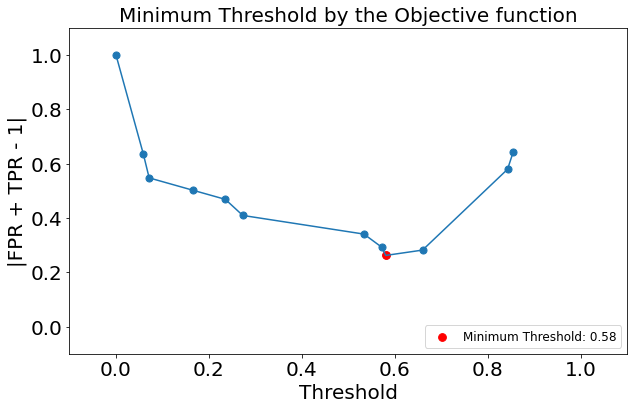

In [20]:
#here i measured with th[np.argmin(np.abs(fpr+tpr-1))] the best threshold (just balancing)
plt.figure(figsize=(10,6))
plt.scatter(th[1:],np.abs(fpr+tpr-1)[1:], s=50)
plt.plot(th[1:],np.abs(fpr+tpr-1)[1:])
itemindex = np.where(th==th[np.argmin(np.abs(fpr+tpr-1))])
plt.xlabel("Threshold", fontsize=20)
plt.ylabel("|FPR + TPR - 1|", fontsize=20)
plt.scatter(th[np.argmin(np.abs(fpr+tpr-1))],np.abs(fpr+tpr-1)[itemindex], c='r', s=60, label='Minimum Threshold: {:.2f}'.format(th[np.argmin(np.abs(fpr+tpr-1))]))
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='lower right',fontsize=12)
plt.title('Minimum Threshold by the Objective function', fontsize=20)
plt.show()

minimo_threshold = th[np.argmin(np.abs(fpr+tpr-1))]

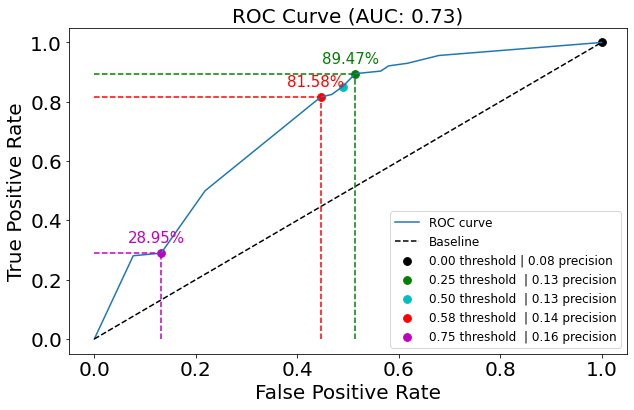

In [21]:
#I wrote a function to plot the roc curve with some info on the graph
def threshold_roc_plotter(X_test, y_test, th_range_array=np.arange(0.001,2.00,0.50)):
    y_score1 = clf.predict_proba(X_test)[:,1]
    
    plt.figure(figsize=(10,6))
    fp_rate, tp_rate, threshold = roc_curve(y_test, y_score1)
    roc_auc = auc(fp_rate, tp_rate)
    
    plt.plot(fp_rate, tp_rate, label='ROC curve')
    plt.plot([0,1], [0,1], 'k--', label='Baseline')
    plt.xlabel('False Positive Rate', fontsize=20)
    plt.ylabel('True Positive Rate', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    colori = {0:'b', 1:'g', 2:'c', 3:'r', 4:'m', 5:'k', 6:'y'}
    
    for i, thr in enumerate(th_range_array):
        if thr==1:
            y_pred_test = [1 if v > thr else 0 for v in y_score1]
        else:
            y_pred_test = [1 if v >= thr else 0 for v in y_score1]
        cf = confusion_matrix(y_test, y_pred_test, labels=[1,0])
        
        TP = cf[0][0]
        FN = cf[0][1]
        FP = cf[1][0]
        TN = cf[1][1]
        
        veri = TP / (TP + FN)
        falsi = FP / (FP + TN)

        if thr >= 1:
            if i <= 6:
                plt.plot([falsi,falsi], [0,veri], str(colori[i])+'--')
                plt.plot([0,falsi], [veri,veri], str(colori[i])+'--')
                plt.scatter(falsi, veri, marker='o', s=60, color='b', label='1.00 threshold')
            else:
                plt.plot([falsi,falsi], [0,veri], str(colori[i-6*(i//6)])+'--')
                plt.plot([0,falsi], [veri,veri], str(colori[i-6*(i//6)])+'--')
                plt.scatter(falsi, veri, marker='o', s=60, color='b', label='1.00 threshold')
            break
        
        if thr == 0.501:
            precision = TP / (TP + FP)
            string_precision = ' | ' + str(round(precision, 2)) + ' precision'
            plt.scatter(falsi, veri, marker='o', s=60, color=str(colori[i]), label='{:.2f} threshold {}'.format(thr, string_precision))

        elif thr > 0 and thr != 0.501:
            precision = TP / (TP + FP)
            string_precision = ' | ' + str(round(precision, 2)) + ' precision'
            if i <= 6:
                plt.plot([falsi,falsi], [0,veri], str(colori[i])+'--')
                plt.plot([0,falsi], [veri,veri], str(colori[i])+'--')
                plt.scatter(falsi, veri, marker='o', s=60, color=str(colori[i]), label='{:.2f} threshold {}'.format(thr, string_precision))
                plt.text(falsi-0.01, veri+0.05, str(round(veri*100,2))+'%', horizontalalignment='center',verticalalignment='center', c=colori[i], fontsize=15)
            else:
                plt.plot([falsi,falsi], [0,veri], str(colori[i-6*(i//6)])+'--')
                plt.plot([0,falsi], [veri,veri], str(colori[i-6*(i//6)])+'--')
                plt.scatter(falsi, veri, marker='o', s=60, color=str(colori[i-6*(i//6)]), label='{:.2f} threshold {}'.format(thr, string_precision))            
        else: # threshold equal to 0
            precision = TP / (TP + FP)
            string_precision = ' | ' + str(round(precision, 2)) + ' precision'
            plt.scatter(falsi, veri, marker='o', s=60, color='k', label='0.00 threshold'+string_precision)            
                
    #plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=14)
    plt.legend(loc='best',fontsize=12)
    plt.title('ROC Curve (AUC: '+str(round(roc_auc,2))+')', fontsize=20)

th_range_array = np.array([0, 0.25, 0.501, minimo_threshold, 0.75])
threshold_roc_plotter(X_test, y_test, th_range_array)

[[ 114    0]
 [1291    0]]
threshold 0.0 precision 0.08 tp_rate (recall):  1.0 fp_rate:  1.0


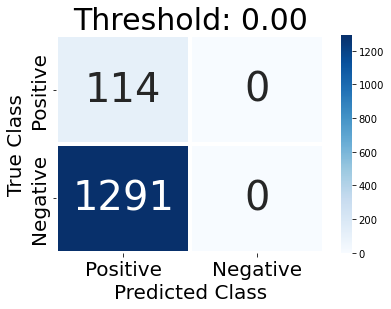

[[102  12]
 [664 627]]
threshold 0.25 precision 0.13 tp_rate (recall):  0.89 fp_rate:  0.51


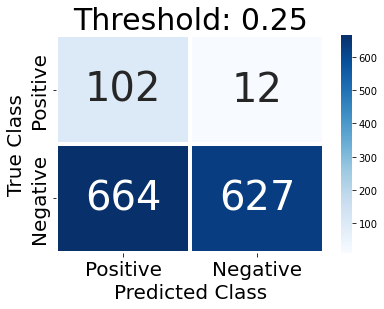

[[ 97  17]
 [632 659]]
threshold 0.501 precision 0.13 tp_rate (recall):  0.85 fp_rate:  0.49


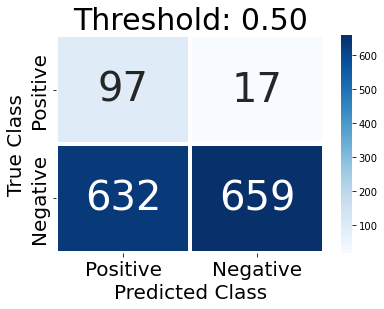

[[ 93  21]
 [576 715]]
threshold 0.5802 precision 0.14 tp_rate (recall):  0.82 fp_rate:  0.45


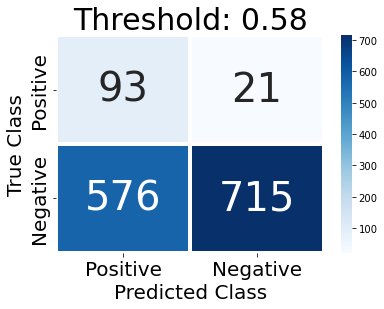

[[  33   81]
 [ 170 1121]]
threshold 0.75 precision 0.16 tp_rate (recall):  0.29 fp_rate:  0.13


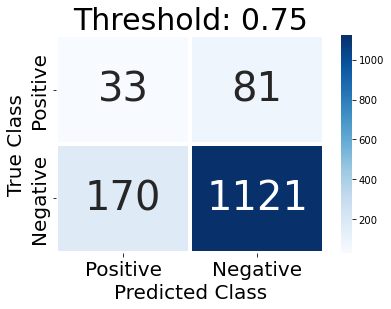

In [22]:
#confusion matrix per threshold
th_range_array = np.array([0, 0.25, 0.501, minimo_threshold, 0.75])
for i, thr in enumerate(th_range_array):
    if thr==1:
        y_pred_test = [1 if v > thr else 0 for v in clf.predict_proba(X_test)[:,1]]
    else:
        y_pred_test = [1 if v >= thr else 0 for v in clf.predict_proba(X_test)[:,1]]
    cf = confusion_matrix(y_test, y_pred_test, labels=[1,0])
    print(cf)
    TP = cf[0][0]
    FN = cf[0][1]
    FP = cf[1][0]
    TN = cf[1][1]

    veri = TP / (TP + FN)
    falsi = FP / (FP + TN)
    precisione = TP / (TP + FP)
    if thr == 0:
        nervi = precisione
    print("threshold", round(thr,4), "precision", round(precisione, 2), "tp_rate (recall): ", round(veri, 2), "fp_rate: ", round(falsi,2))
    
    fig, ax = plt.subplots(figsize=(6,4)) 
    sns.heatmap(cf, annot=True, annot_kws={"size": 40}, linewidths=4, cmap="Blues", fmt='g')
    
    ax.set_xticklabels(['Positive','Negative'], fontsize=20)
    ax.set_xlabel('Predicted Class', fontsize=20)
    ax.set_yticklabels(['Positive','Negative'], verticalalignment='center', fontsize=20)
    ax.set_ylabel('True Class', fontsize=20)
    
    plt.title('Threshold: {:.2f}'.format(thr), fontsize=30)
    #specify your path
    plt.show()

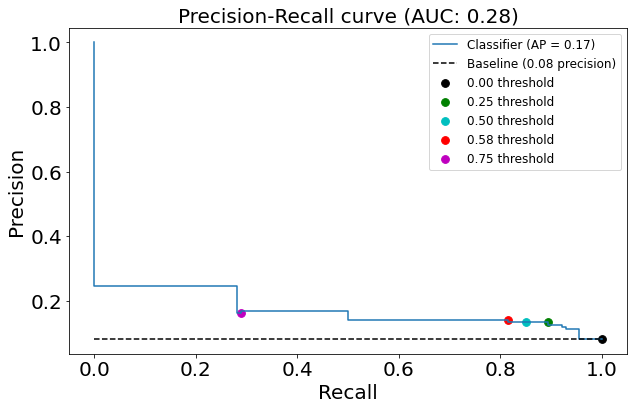

In [23]:
fig = plt.figure(figsize=(10,6))
ax = plt.axes()
display = PrecisionRecallDisplay.from_predictions(y_test, y_score[:,1], ax = ax)
display.ax_.set_title("Precision-Recall curve (AUC: {:.2f})".format(proc_auc), fontsize=20)
plt.plot([0,1], [nervi,nervi], '--k', label='Baseline ({:0.2f} precision)'.format(nervi))
plt.xlabel('Recall', fontsize=20)
plt.ylabel('Precision', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

colori = {0:'k', 1:'g', 2:'c', 3:'r', 4:'m', 5:'y', 6:'b'}

for i, thr in enumerate(th_range_array):
    if thr==1:
        y_pred_test = [1 if v > thr else 0 for v in clf.predict_proba(X_test)[:,1]]
    else:
        y_pred_test = [1 if v >= thr else 0 for v in clf.predict_proba(X_test)[:,1]]
    cf = confusion_matrix(y_test, y_pred_test, labels=[1,0])
    TP = cf[0][0]
    FN = cf[0][1]
    FP = cf[1][0]
    TN = cf[1][1]

    veri = TP / (TP + FN) #recall
    falsi = FP / (FP + TN)
    if thr != 1:
        precisione = TP / (TP + FP)
        plt.scatter(veri, precisione, c=str(colori[i]), s=60, label='{:.2f} threshold'.format(thr))

plt.legend(fontsize=12)

<b>KNN</b>

In [24]:
gs = {'n_neighbors' : np.arange(1,25)}
knn_param_search = GridSearchCV(KNeighborsClassifier(), gs, cv = ms.KFold(n_splits=5), scoring='f1')
knn_param_search.fit(knnX_train, knny_train)
knn_param_search.best_params_

{'n_neighbors': 13}

In [25]:
res = knn_param_search.cv_results_ 
def report(results, n_top=10):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
report(res, n_top=10)

Model with rank: 1
Mean validation score: 0.703 (std: 0.039)
Parameters: {'n_neighbors': 13}

Model with rank: 2
Mean validation score: 0.698 (std: 0.017)
Parameters: {'n_neighbors': 21}

Model with rank: 3
Mean validation score: 0.698 (std: 0.036)
Parameters: {'n_neighbors': 11}

Model with rank: 4
Mean validation score: 0.697 (std: 0.017)
Parameters: {'n_neighbors': 20}

Model with rank: 5
Mean validation score: 0.696 (std: 0.033)
Parameters: {'n_neighbors': 17}

Model with rank: 6
Mean validation score: 0.696 (std: 0.026)
Parameters: {'n_neighbors': 18}

Model with rank: 7
Mean validation score: 0.695 (std: 0.030)
Parameters: {'n_neighbors': 15}

Model with rank: 8
Mean validation score: 0.694 (std: 0.024)
Parameters: {'n_neighbors': 19}

Model with rank: 9
Mean validation score: 0.694 (std: 0.029)
Parameters: {'n_neighbors': 16}

Model with rank: 10
Mean validation score: 0.693 (std: 0.021)
Parameters: {'n_neighbors': 22}



In [26]:
k = 13
kclf = KNeighborsClassifier(n_neighbors=k)
kclf.fit(knnX_train, knny_train)
scores = cross_val_score(kclf, knnX_train, knny_train, cv=ms.KFold(n_splits=5), scoring='f1')
print(k, scores.mean(), scores.std())

13 0.7030685779035031 0.039181989529018586


In [27]:
knny_pred_train = kclf.predict(knnX_train)
print(classification_report(knny_train, knny_pred_train))

              precision    recall  f1-score   support

           0       0.80      0.56      0.66       265
           1       0.66      0.86      0.75       265

    accuracy                           0.71       530
   macro avg       0.73      0.71      0.70       530
weighted avg       0.73      0.71      0.70       530



In [28]:
kcf = confusion_matrix(knny_train, knny_pred_train, labels=[1,0])
print("True Positives: "+str(cf[0][0]), "False Negatives: "+str(cf[0][1]), "False Positives: "+str(cf[1][0]), "True Negatives: "+str(cf[1][1]), sep='\n')

True Positives: 33
False Negatives: 81
False Positives: 170
True Negatives: 1121


In [29]:
knny_pred_test = kclf.predict(knnX_test)
print(classification_report(knny_test, knny_pred_test))

              precision    recall  f1-score   support

           0       0.97      0.59      0.73      1291
           1       0.15      0.82      0.25       114

    accuracy                           0.61      1405
   macro avg       0.56      0.71      0.49      1405
weighted avg       0.91      0.61      0.69      1405



In [30]:
print("Predicted as negatives:", len(knny_pred_test[knny_pred_test == 0]), "\nPredicted as positives:", len(knny_pred_test[knny_pred_test == 1]), "\n")
kcf_test = confusion_matrix(knny_test, knny_pred_test, labels=[1,0])
print("TP: "+str(cf_test[0][0]), "FN: "+str(cf_test[0][1]), "FP: "+str(cf_test[1][0]), "TN: "+str(cf_test[1][1]), sep='\n')

Predicted as negatives: 777 
Predicted as positives: 628 

TP: 97
FN: 17
FP: 632
TN: 659


In [31]:
knny_score = kclf.predict_proba(knnX_test)
kfpr, ktpr, kth = roc_curve(knny_test, knny_score[:,1])
kroc_auc = auc(kfpr, ktpr)

kprecision, krecall, _ = precision_recall_curve(knny_test, knny_score[:,1])
kproc_auc = auc(krecall, kprecision)

print('ROC AUC:', kroc_auc)
print('PR Curve AUC:', kproc_auc)

ROC AUC: 0.7620741435307866
PR Curve AUC: 0.1857893857518282


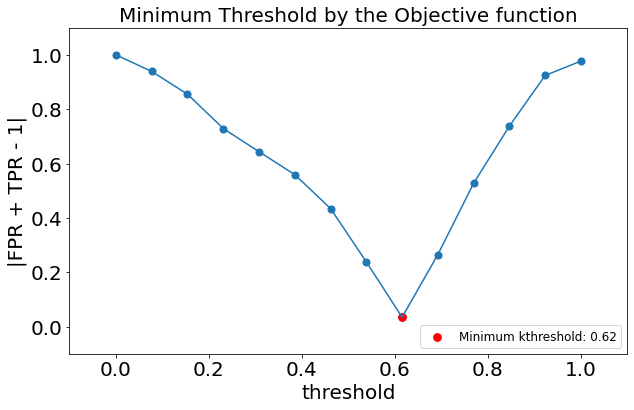

In [32]:
plt.figure(figsize=(10,6))
plt.scatter(kth[1:],np.abs(kfpr+ktpr-1)[1:], s=50)
plt.plot(kth[1:],np.abs(kfpr+ktpr-1)[1:])
kitemindex = np.where(kth==kth[np.argmin(np.abs(kfpr+ktpr-1))])
plt.xlabel("threshold", fontsize=20)
plt.ylabel("|FPR + TPR - 1|", fontsize=20)
plt.scatter(kth[np.argmin(np.abs(kfpr+ktpr-1))],np.abs(kfpr+ktpr-1)[kitemindex], c='r', s=60, label='Minimum kthreshold: {:.2f}'.format(kth[np.argmin(np.abs(kfpr+ktpr-1))]))
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='lower right',fontsize=12)
plt.title('Minimum Threshold by the Objective function', fontsize=20)
plt.show()

kminimo_kthreshold = kth[np.argmin(np.abs(kfpr+ktpr-1))]

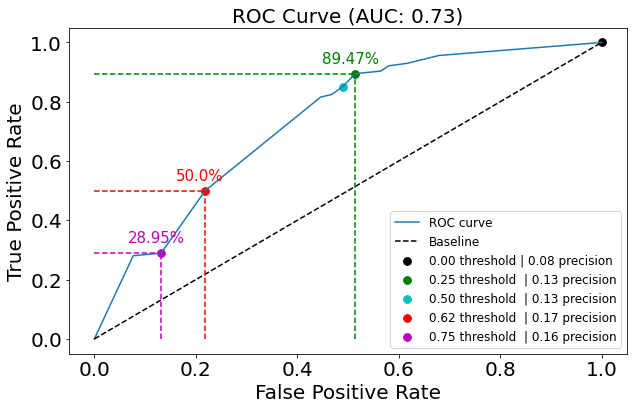

In [33]:
kth_range_array = np.array([0, 0.25, 0.501, kminimo_kthreshold, 0.75])
threshold_roc_plotter(knnX_test, knny_test, kth_range_array)

[[ 114    0]
 [1291    0]]
threshold 0.0 precision 0.08 tp_rate (recall):  1.0 fp_rate:  1.0


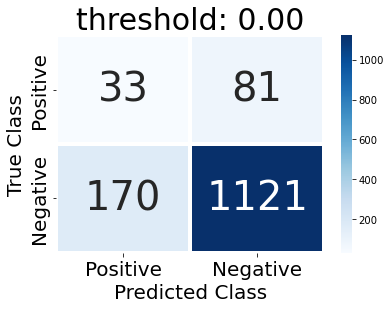

[[110   4]
 [876 415]]
threshold 0.25 precision 0.11 tp_rate (recall):  0.96 fp_rate:  0.68


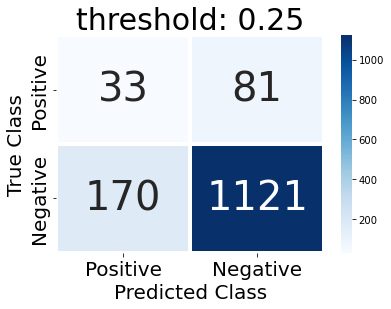

[[ 94  20]
 [534 757]]
threshold 0.501 precision 0.15 tp_rate (recall):  0.82 fp_rate:  0.41


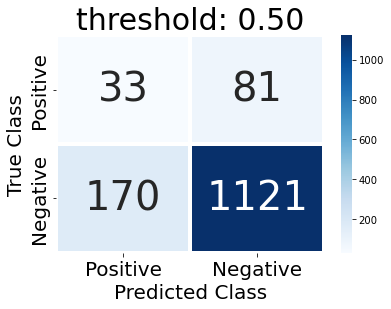

[[ 82  32]
 [407 884]]
threshold 0.6154 precision 0.17 tp_rate (recall):  0.72 fp_rate:  0.32


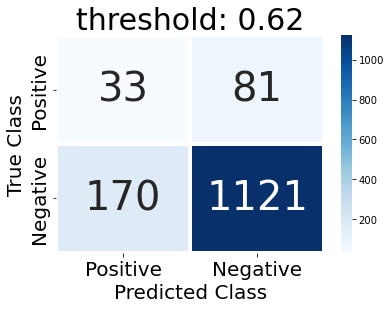

[[  40   74]
 [ 157 1134]]
threshold 0.75 precision 0.2 tp_rate (recall):  0.35 fp_rate:  0.12


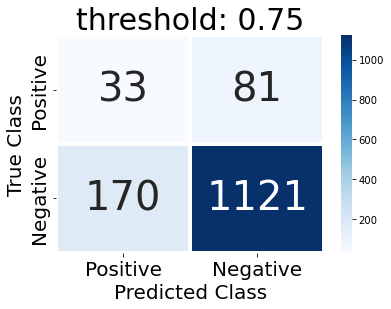

In [34]:
kth_range_array = np.array([0, 0.25, 0.501, kminimo_kthreshold, 0.75])
for i, thr in enumerate(kth_range_array):
    if thr==1:
        knny_pred_test = [1 if v > thr else 0 for v in kclf.predict_proba(knnX_test)[:,1]]
    else:
        knny_pred_test = [1 if v >= thr else 0 for v in kclf.predict_proba(knnX_test)[:,1]]
    kcf = confusion_matrix(knny_test, knny_pred_test, labels=[1,0])
    print(kcf)
    kTP = kcf[0][0]
    kFN = kcf[0][1]
    kFP = kcf[1][0]
    kTN = kcf[1][1]

    kveri = kTP / (kTP + kFN)
    kfalsi = kFP / (kFP + kTN)
    kprecisione = kTP / (kTP + kFP)
    if thr == 0:
        knervi = kprecisione
    
    print("threshold", round(thr,4), "precision", round(kprecisione, 2), "tp_rate (recall): ", round(kveri, 2), "fp_rate: ", round(kfalsi,2))
    
    fig, ax = plt.subplots(figsize=(6,4)) 
    sns.heatmap(cf, annot=True, annot_kws={"size": 40}, linewidths=4, cmap="Blues", fmt='g')
    
    ax.set_xticklabels(['Positive','Negative'], fontsize=20)
    ax.set_xlabel('Predicted Class', fontsize=20)
    ax.set_yticklabels(['Positive','Negative'], verticalalignment='center', fontsize=20)
    ax.set_ylabel('True Class', fontsize=20)
    
    plt.title('threshold: {:.2f}'.format(thr), fontsize=30)
    
    plt.show()

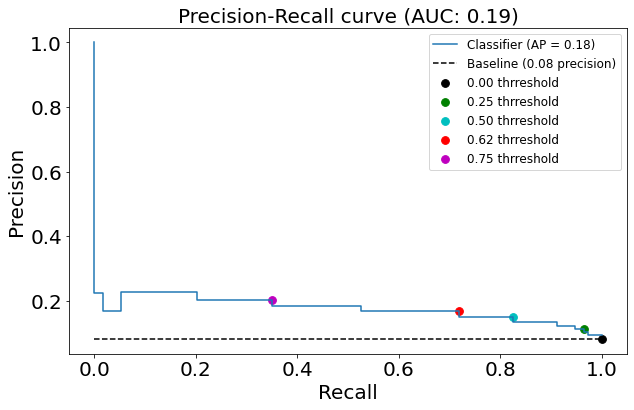

In [35]:
fig = plt.figure(figsize=(10,6))
ax = plt.axes()
display = PrecisionRecallDisplay.from_predictions(knny_test, knny_score[:,1], ax = ax)
display.ax_.set_title("Precision-Recall curve (AUC: {:.2f})".format(kproc_auc), fontsize=20)
plt.plot([0,1], [knervi,knervi], '--k', label='Baseline ({:0.2f} precision)'.format(knervi))
plt.xlabel('Recall', fontsize=20)
plt.ylabel('Precision', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

colori = {0:'k', 1:'g', 2:'c', 3:'r', 4:'m', 5:'y', 6:'b'}

for i, thr in enumerate(kth_range_array):
    if thr==1:
        knny_pred_test = [1 if v > thr else 0 for v in kclf.predict_proba(knnX_test)[:,1]]
    else:
        knny_pred_test = [1 if v >= thr else 0 for v in kclf.predict_proba(knnX_test)[:,1]]
    kcf = confusion_matrix(knny_test, knny_pred_test, labels=[1,0])
    kTP = kcf[0][0]
    kFN = kcf[0][1]
    kFP = kcf[1][0]
    kTN = kcf[1][1]

    kveri = kTP / (kTP + kFN)
    kfalsi = kFP / (kFP + kTN)
    if thr != 1:
        kprecisione = kTP / (kTP + kFP)
        plt.scatter(kveri, kprecisione, c=str(colori[i]), s=60, label='{:.2f} thrreshold'.format(thr))

plt.legend(fontsize=12)

<b>Comparison between the two algorithms</b>

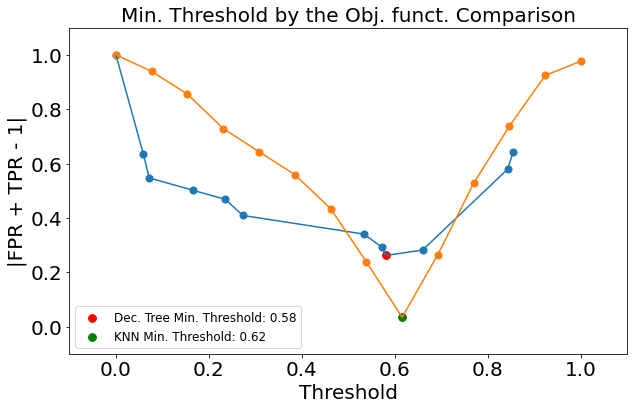

In [36]:
plt.figure(figsize=(10,6))
plt.scatter(th[1:],np.abs(fpr+tpr-1)[1:], s=50)
plt.plot(th[1:],np.abs(fpr+tpr-1)[1:])
plt.xlabel("Threshold", fontsize=20)
plt.ylabel("|FPR + TPR - 1|", fontsize=20)
plt.scatter(minimo_threshold, np.abs(fpr+tpr-1)[itemindex], c='r', s=60, label='Dec. Tree Min. Threshold: {:.2f}'.format(minimo_threshold))

plt.scatter(kth[1:],np.abs(kfpr+ktpr-1)[1:], s=50)
plt.plot(kth[1:],np.abs(kfpr+ktpr-1)[1:])
plt.xlabel("Threshold", fontsize=20)
plt.ylabel("|FPR + TPR - 1|", fontsize=20)
plt.scatter(kminimo_kthreshold, np.abs(kfpr+ktpr-1)[kitemindex], c='g', s=60, label='KNN Min. Threshold: {:.2f}'.format(kminimo_kthreshold))

plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='lower left',fontsize=12)
plt.title('Min. Threshold by the Obj. funct. Comparison', fontsize=20)
plt.show()

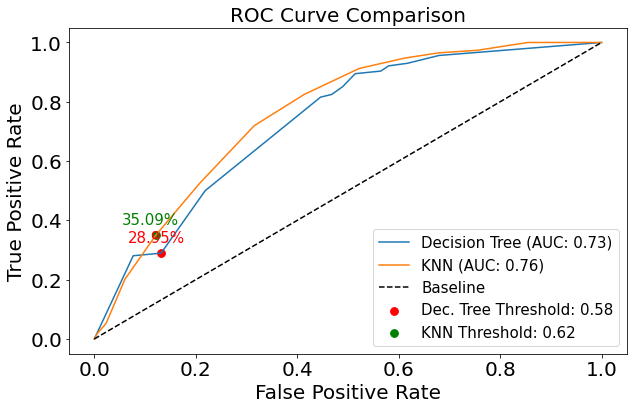

In [37]:
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, label='Decision Tree (AUC: {:.2f})'.format(roc_auc))
plt.plot(kfpr, ktpr, label='KNN (AUC: {:.2f})'.format(kroc_auc))
plt.plot([0,1], [0,1], 'k--', label='Baseline')
plt.scatter(falsi, veri, c='r', s=60, label = "Dec. Tree Threshold: {:.2f}".format(minimo_threshold))
plt.text(falsi-0.01, veri+0.05, str(round(veri*100,2))+'%', horizontalalignment='center',verticalalignment='center', c='r', fontsize=15)
plt.scatter(kfalsi, kveri, c='g', s=60, label = "KNN Threshold: {:.2f}".format(kminimo_kthreshold))
plt.text(kfalsi-0.01, kveri+0.05, str(round(kveri*100,2))+'%', horizontalalignment='center',verticalalignment='center', c='g', fontsize=15)
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.title('ROC Curve Comparison', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15)

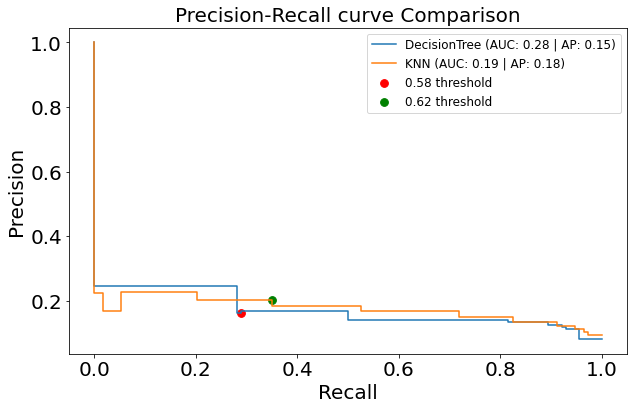

In [38]:
fig = plt.figure(figsize=(10,6))
ax = plt.axes()
display = PrecisionRecallDisplay.from_predictions(y_test, y_score[:,1], ax = ax, label="DecisionTree (AUC: {:.2f} | AP: {:.2f})".format(proc_auc, 0.15))
display = PrecisionRecallDisplay.from_predictions(knny_test, knny_score[:,1], ax = ax, label="KNN (AUC: {:.2f} | AP: {:.2f})".format(kproc_auc, 0.18))
display.ax_.set_title("Precision-Recall curve Comparison", fontsize=20)
plt.xlabel('Recall', fontsize=20)
plt.ylabel('Precision', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.scatter(veri, precisione, c='r', s=60, label='{:.2f} threshold'.format(minimo_threshold))
plt.scatter(kveri, kprecisione, c='g', s=60, label='{:.2f} threshold'.format(kminimo_kthreshold))
plt.legend(fontsize=12)

In [39]:
lista = [1 if v >= minimo_threshold else 0 for v in y_score[:,1]]
klista = [1 if v >= kminimo_kthreshold else 0 for v in knny_score[:,1]]

print("DECISION TREE (THRESHOLD " + str(round(minimo_threshold, 2)) + "):\n" , classification_report(y_test, lista) )
print("KNN (THRESHOLD " + str(round(kminimo_kthreshold, 2)) + "):\n" , classification_report(y_test, klista) )

DECISION TREE (THRESHOLD 0.58):
               precision    recall  f1-score   support

           0       0.97      0.55      0.71      1291
           1       0.14      0.82      0.24       114

    accuracy                           0.58      1405
   macro avg       0.56      0.68      0.47      1405
weighted avg       0.90      0.58      0.67      1405

KNN (THRESHOLD 0.62):
               precision    recall  f1-score   support

           0       0.97      0.68      0.80      1291
           1       0.17      0.72      0.27       114

    accuracy                           0.69      1405
   macro avg       0.57      0.70      0.54      1405
weighted avg       0.90      0.69      0.76      1405

